In [234]:
import io
from google.colab import files
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Input
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from math import isnan
import seaborn as sn
import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.merge import concatenate
from keras.models import Model
from google.colab import drive
%matplotlib inline

In [235]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inspect the data

In [236]:
with open('/content/drive/MyDrive/MachineLearningProject/Dataset/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv', 'r') as f:
  hist = pd.read_csv(f)

In [237]:
hist.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
hist.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4727767,1609372260,28836.97,28849.67,28807.78,28826.52,2.051917,59173.965272,28838.376450
4727768,1609372320,28826.49,28844.25,28816.09,28816.09,0.721410,20803.457100,28837.207539
4727769,1609372380,28814.36,28822.71,28800.00,28800.00,1.529671,44076.572351,28814.411945
4727770,1609372440,28800.00,28832.79,28800.00,28831.35,2.036450,58675.679644,28812.732950
4727771,1609372500,28809.07,28825.50,28800.01,28810.08,0.087391,2517.799582,28810.597267
4727772,1609372560,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,1609372620,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,1609372680,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
4727775,1609372740,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831
4727776,1609372800,28893.21,28928.49,28893.21,28928.49,5.757679,166449.709320,28909.166061


In [239]:
hist_copy = hist.copy()
hist.shape

(4727777, 8)

In [240]:
hist["Close"].max()

28997.38

In [207]:
hist["Open"].max()

28997.38

In [241]:
hist = hist.set_index(['Timestamp'])
hist.index = pd.to_datetime(hist.index, unit='s')

In [209]:
hist.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
hist.tail(11)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-30 23:50:00,28816.76,28842.41,28800.00,28836.97,0.209298,6033.945519,28829.425958
2020-12-30 23:51:00,28836.97,28849.67,28807.78,28826.52,2.051917,59173.965272,28838.376450
2020-12-30 23:52:00,28826.49,28844.25,28816.09,28816.09,0.721410,20803.457100,28837.207539
2020-12-30 23:53:00,28814.36,28822.71,28800.00,28800.00,1.529671,44076.572351,28814.411945
2020-12-30 23:54:00,28800.00,28832.79,28800.00,28831.35,2.036450,58675.679644,28812.732950
2020-12-30 23:55:00,28809.07,28825.50,28800.01,28810.08,0.087391,2517.799582,28810.597267
2020-12-30 23:56:00,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
2020-12-30 23:57:00,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
2020-12-30 23:58:00,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266


In [242]:
hist_10min = hist.resample('10Min')
hist_10min.asfreq()[0:5]   # Select first 5 rows

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 08:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
hist_10min.asfreq().tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-30 23:20:00,28791.40,28809.16,28773.41,28809.16,3.670326,105720.839210,28804.205701
2020-12-30 23:30:00,28835.96,28865.33,28822.74,28858.72,1.568518,45235.148066,28839.418978
2020-12-30 23:40:00,28874.00,28899.37,28868.04,28884.84,1.156029,33377.945254,28872.926497
2020-12-30 23:50:00,28816.76,28842.41,28800.00,28836.97,0.209298,6033.945519,28829.425958
2020-12-31 00:00:00,28893.21,28928.49,28893.21,28928.49,5.757679,166449.709320,28909.166061


In [244]:
hist_10min = hist_10min.asfreq()
hist_10min.shape

(473426, 7)

In [245]:
hist_10min.isnull().sum()

Open                 117149
High                 117149
Low                  117149
Close                117149
Volume_(BTC)         117149
Volume_(Currency)    117149
Weighted_Price       117149
dtype: int64

In [246]:
def replace_NaN(df):
  old_df = df.copy()
  for row_index, row in old_df.iterrows():
     column_index = 0
     for value in row:
       if isnan(value):
         df.iloc[row_index, column_index] = df.iloc[row_index-1, column_index] 
       column_index += 1

In [216]:
def replace_NaN_with_median(data):
  data['Open'] = data['Open'].fillna(data['Open'].median())
  data['High'] = data['High'].fillna(data['High'].median())
  data['Low'] = data['Low'].fillna(data['Low'].median())
  data['Close'] = data['Close'].fillna(data['Close'].median())
  data['Volume_(BTC)'] = data['Volume_(BTC)'].fillna(data['Volume_(BTC)'].median())
  data['Volume_(Currency)'] = data['Volume_(Currency)'].fillna(data['Volume_(Currency)'].median())
  data['Weighted_Price'] = data['Weighted_Price'].fillna(data['Weighted_Price'].median())


In [247]:
hist_10min = hist_10min.dropna(axis = 0, how = 'any')

In [248]:
hist_10min.isnull().sum() #Should be zero

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

# Test-Train split

In [249]:
def train_test_split(array, test_size=0.2):
    split_row = len(array) - int(test_size * len(array))
    train_data = array[:split_row]
    test_data = array[split_row:]
    return train_data, test_data
    
train, test = train_test_split(hist_10min, test_size=0.2)

In [250]:
target_col = 'Close'
target_index = 3
hist_10min.iloc[1:5, target_index]

Timestamp
2011-12-31 17:00:00    4.58
2012-01-03 17:10:00    5.29
2012-01-04 16:00:00    5.37
2012-01-05 01:40:00    5.72
Name: Close, dtype: float64

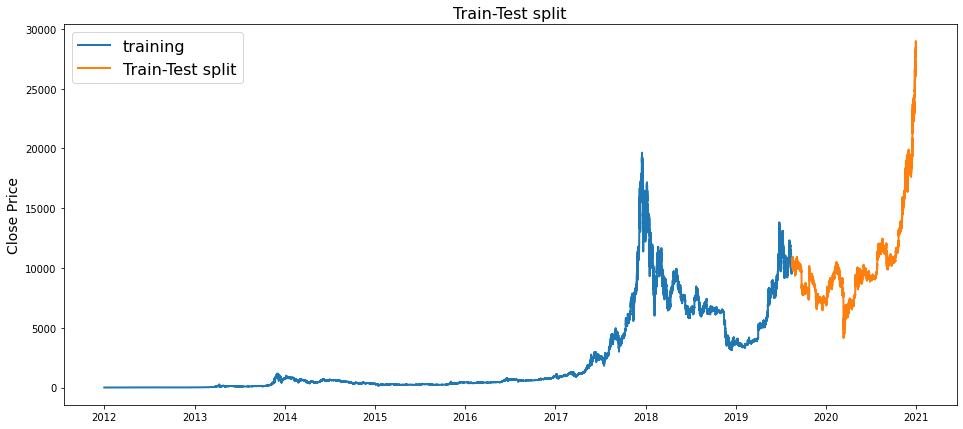

In [251]:
def line_plot(line1, line2, label1=None, label2=None, title='Train-Test split', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Close Price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot(train[target_col], test[target_col], 'training', 'Train-Test split')

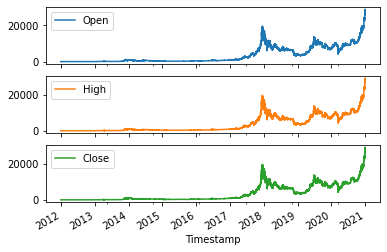

In [252]:
plot_cols = ['Open', 'High', 'Close']
plot_features = hist_10min[plot_cols]
_ = plot_features.plot(subplots=True)

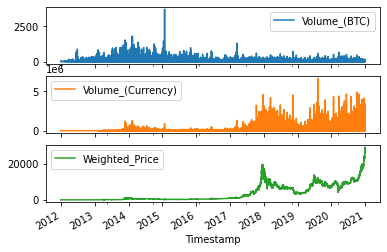

In [253]:
plot_cols = ['Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']
plot_features = hist_10min[plot_cols]
_ = plot_features.plot(subplots=True)



# Standardization

In [ ]:
#target = hist_10min[target_col].to_numpy()
#target = target.reshape(-1,1)
#scaler = StandardScaler()

#scaler2 = StandardScaler()
#scaler2.fit(target)

#hist_array = scaler.fit_transform(hist_10min)

In [254]:
target = hist_10min[target_col].to_numpy()
target = target.reshape(-1,1)
scaler = MinMaxScaler()

scaler2 = MinMaxScaler()
scaler2.fit(target)

hist_array = scaler.fit_transform(hist_10min)

In [255]:
hist_10min = pd.DataFrame(hist_array, columns=hist_10min.columns)

In [256]:
target.shape

(356277, 1)

In [257]:
hist_10min.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,0.000004,0.000004,0.000004,0.000004,0.013005,0.000032,0.000004
1,0.000011,0.000011,0.000011,0.000011,0.002438,0.000006,0.000011
2,0.000035,0.000035,0.000035,0.000035,0.003058,0.000009,0.000035
3,0.000038,0.000038,0.000038,0.000038,0.003693,0.000011,0.000038
4,0.000050,0.000050,0.000050,0.000050,0.001355,0.000004,0.000050


In [258]:
hist_10min.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
356272,0.992896,0.993144,0.994651,0.995536,0.000994,0.015897,0.994753
356273,0.994432,0.995081,0.996356,0.997249,0.000425,0.006802,0.995969
356274,0.995745,0.996255,0.997922,0.998152,0.000313,0.005019,0.997127
356275,0.993770,0.994291,0.995570,0.996497,0.000057,0.000907,0.995624
356276,0.996407,0.997259,0.998793,0.999660,0.001560,0.025028,0.998379


In [259]:
hist_10min.shape

(356277, 7)



# Data windowing

In [260]:
def extract_window_data(array, window_len=6):
  X = []
  y  = []
  for i in range(window_len, len(array)-window_len):
      X.append(array[i-window_len:i])
      y.append(array[i:i+window_len, target_index])
  X, y = np.array(X), np.array(y)
  return X, y

In [261]:
def prepare_data(array, target_col, window_len=60, test_size=0.2):
    #We split the dataset into train and test
    train_data, test_data = train_test_split(array, test_size=test_size)
    #We extract all the possible windows
    X_train, y_train = extract_window_data(train_data, window_len)
    #We extract all the possible windows
    X_test, y_test = extract_window_data(test_data, window_len)
   
    return X_train, y_train, X_test, y_test

# LSTM model

In [262]:
def build_lstm_model(window_len, num_features, output_size, neurons=50, activ_func='linear', dropout=0.2, loss='mape', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(window_len, num_features)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mape'])
    
    return model

**Parameters**

In [263]:
np.random.seed(42)
window_len = 6
test_size = 0.2
lstm_neurons = 100
epochs = 10
num_features = len(hist_10min.columns)
activ_func = 'linear'
batch_size = 128
loss = 'mape'
dropout = 0.2
output_size = 6
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [264]:
X_train, y_train, X_test, y_test = prepare_data(hist_array, target_col, window_len=window_len, test_size=test_size)

In [265]:
X_train.shape

(285010, 6, 7)

In [ ]:
y_train.shape

(285010, 6)

In [266]:
model = build_lstm_model(window_len, num_features, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               43200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 606       
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 43,806
Trainable params: 43,806
Non-trainable params: 0
_________________________________________________________________


In [267]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/10
2227/2227 [==============================] - 27s 12ms/step - loss: 39.7736 - mape: 39.7736
Epoch 2/10
2227/2227 [==============================] - 26s 12ms/step - loss: 36.3543 - mape: 36.3543
Epoch 3/10
2227/2227 [==============================] - 26s 12ms/step - loss: 51.5407 - mape: 51.5407
Epoch 4/10
2227/2227 [==============================] - 26s 12ms/step - loss: 31.6174 - mape: 31.6174
Epoch 5/10
2227/2227 [==============================] - 26s 12ms/step - loss: 36.2769 - mape: 36.2769
Epoch 6/10
2227/2227 [==============================] - 26s 12ms/step - loss: 38.2546 - mape: 38.2546
Epoch 7/10
2227/2227 [==============================] - 26s 12ms/step - loss: 23.2385 - mape: 23.2385
Epoch 8/10
2227/2227 [==============================] - 26s 12ms/step - loss: 60.9151 - mape: 60.9151
Epoch 9/10
2227/2227 [==============================] - 26s 12ms/step - loss: 25.3867 - mape: 25.3867
Epoch 10/10
2227/2227 [==============================] - 26s 12ms/step - loss: 39.

In [278]:
history.history

{'loss': [39.039337158203125,
  36.5673713684082,
  39.82292556762695,
  34.544254302978516,
  33.7811164855957,
  34.75555419921875,
  31.975873947143555,
  33.78561019897461,
  27.100421905517578,
  31.65580940246582],
 'mape': [39.039337158203125,
  36.5673713684082,
  39.82292556762695,
  34.544254302978516,
  33.7811164855957,
  34.75555419921875,
  31.975873947143555,
  33.78561019897461,
  27.100421905517578,
  31.65580940246582]}

In [268]:
results = model.evaluate(X_test, y_test)
print("test loss:", results)

2227/2227 [==============================] - 5s 2ms/step - loss: 1.7887 - mape: 1.7887
test loss: [1.7887499332427979, 1.7887499332427979]


In [269]:
preds = model.predict(X_test)

In [270]:
preds.shape

(71243, 6)

In [271]:
y_test.shape

(71243, 6)

In [272]:
predictions = scaler2.inverse_transform(preds)
real_values = scaler2.inverse_transform(y_test)

In [273]:
def plot(real_values, predictions,  plot_col='Close', max_subplots=5, print_step  = 10000):
  plt.figure(figsize=(12, 8))
  x = []
  for i in range(6):
    x.append(i+1) 
  for n in range(max_subplots):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.scatter(x, real_values[print_step * n], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(x, predictions[print_step * n], marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

  plt.xlabel('Time [1h]')


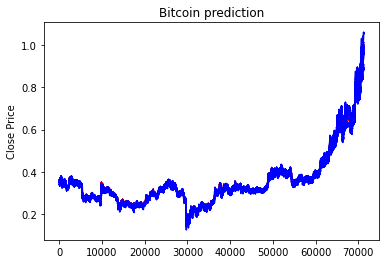

In [274]:
# Visualizing the results
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

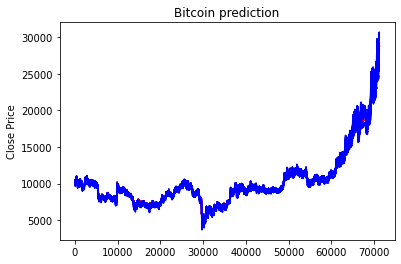

In [275]:
# Visualizing the results
plt.plot(real_values, color = 'red', label = 'Real')
plt.plot(predictions, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

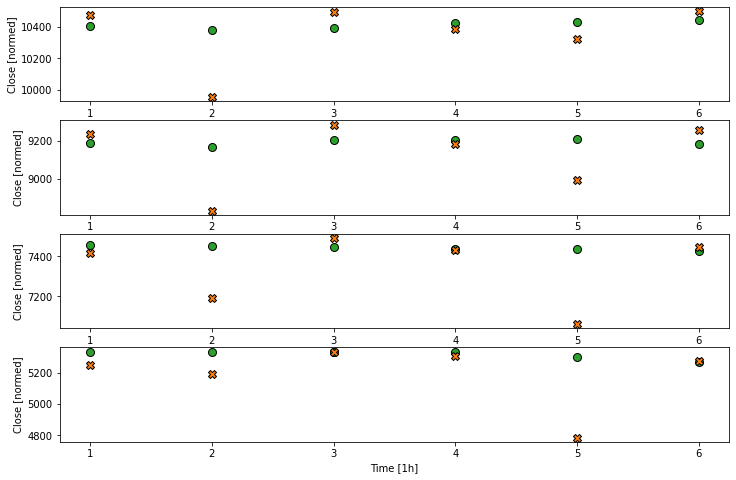

In [279]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=4, print_step = 10000)

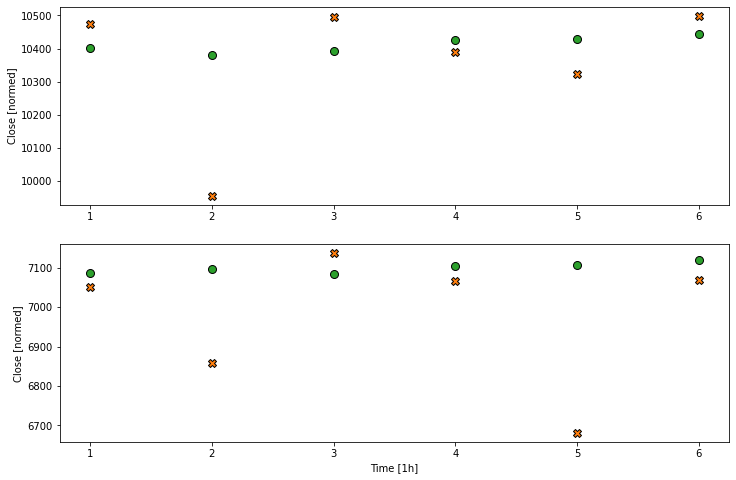

In [280]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=2, print_step = 35000)

In [ ]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("/content/drive/My Drive/MachineLearningProject/nn_for_bitcoin_price_1h.h5")


# Convolutional Model

In [281]:
np.random.seed(42)
window_len = 6
test_size = 0.2
epochs = 10
num_features = len(hist.columns)
batch_size = 128
loss = 'mape'
dropout = 0.2
output_size = 6
optimizer = keras.optimizers.Adam(learning_rate=0.00003)

In [282]:
def build_conv_model(output_size, neurons=512, loss='mape', optimizer='adam'):
    CONV_WIDTH = 3
    model = Sequential()
    model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]))
    model.add(tf.keras.layers.Conv1D(neurons, activation='relu', kernel_size=(CONV_WIDTH)))
    model.add(tf.keras.layers.Dense(output_size, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([output_size]))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mape'])
    return model

In [283]:
model = build_conv_model(output_size=output_size, loss=loss, optimizer=optimizer)

In [284]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/10
2227/2227 [==============================] - 5s 2ms/step - loss: 38.1811 - mape: 38.1811
Epoch 2/10
2227/2227 [==============================] - 5s 2ms/step - loss: 4.4516 - mape: 4.4516
Epoch 3/10
2227/2227 [==============================] - 5s 2ms/step - loss: 5.4856 - mape: 5.4856
Epoch 4/10
2227/2227 [==============================] - 5s 2ms/step - loss: 2.4959 - mape: 2.4959
Epoch 5/10
2227/2227 [==============================] - 5s 2ms/step - loss: 5.0461 - mape: 5.0461
Epoch 6/10
2227/2227 [==============================] - 5s 2ms/step - loss: 3.6956 - mape: 3.6956
Epoch 7/10
2227/2227 [==============================] - 5s 2ms/step - loss: 4.9588 - mape: 4.9588
Epoch 8/10
2227/2227 [==============================] - 5s 2ms/step - loss: 7.7197 - mape: 7.7197
Epoch 9/10
2227/2227 [==============================] - 5s 2ms/step - loss: 6.7660 - mape: 6.7660
Epoch 10/10
2227/2227 [==============================] - 5s 2ms/step - loss: 4.3179 - mape: 4.3179


In [285]:
results = model.evaluate(X_test, y_test)

2227/2227 [==============================] - 2s 1ms/step - loss: 0.9121 - mape: 0.9121


In [286]:
preds = model.predict(X_test)

In [287]:
predictions = scaler2.inverse_transform(preds)
real_values = scaler2.inverse_transform(y_test)

In [288]:
predictions.shape

(71243, 6)

In [289]:
y_test.shape

(71243, 6)

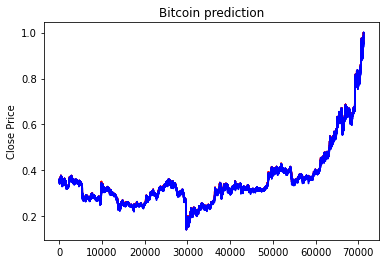

In [290]:
# Visualizing the results
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

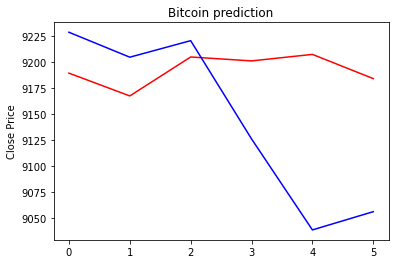

In [297]:
# Visualizing the results
plt.plot(real_values[10000], color = 'red', label = 'Real')
plt.plot(predictions[10000], color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

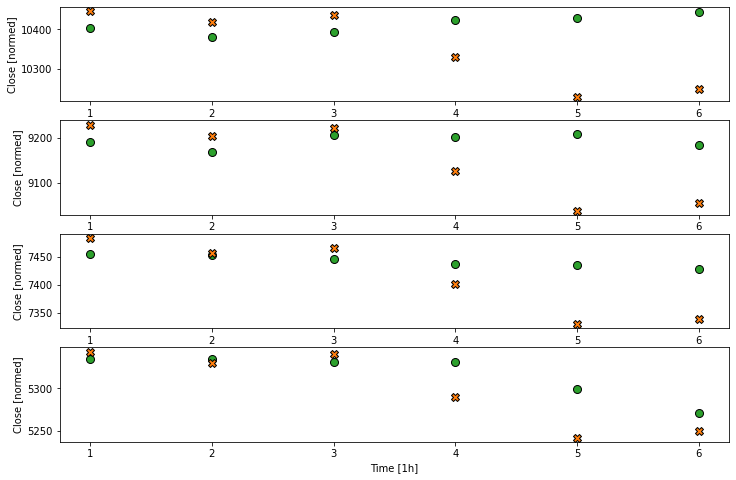

In [298]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=4, print_step = 10000)

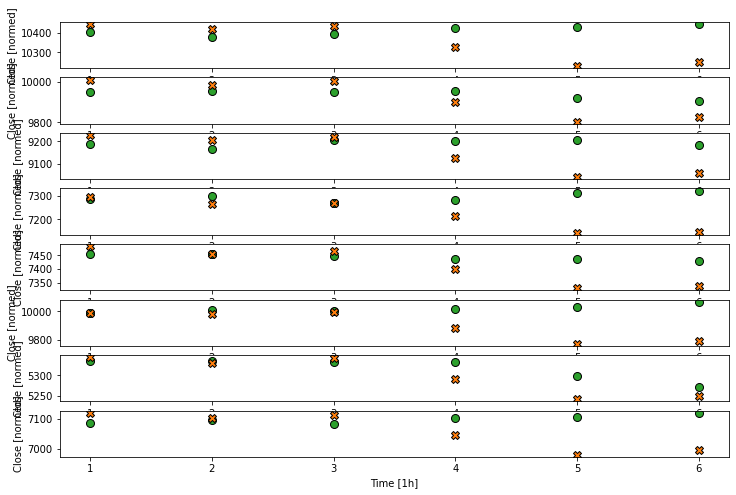

In [293]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=8, print_step = 5000)

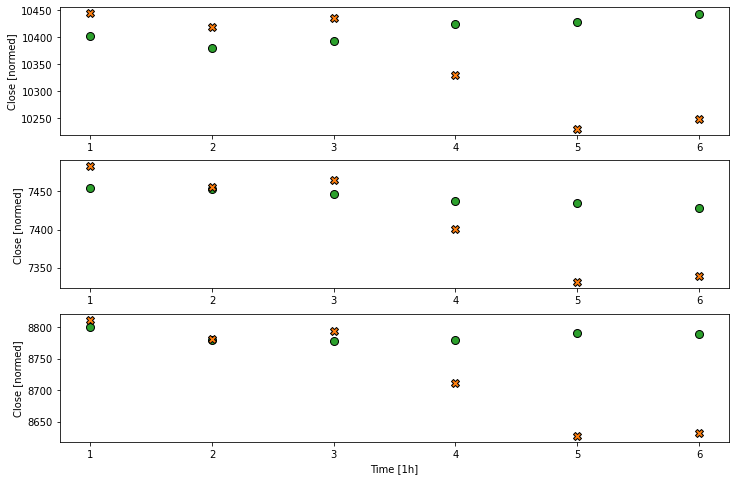

In [294]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=3, print_step = 20000)

In [295]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("/content/drive/My Drive/MachineLearningProject/cnn_for_bitcoin_price_60min.h5")

# Convolutional Model 2

In [299]:
np.random.seed(42)
window_len = 6
test_size = 0.2
epochs = 10
num_features = len(hist.columns)
batch_size = 256
loss = 'mape'
dropout = 0.2
output_size = 6
optimizer = keras.optimizers.Adam(learning_rate=0.000003)

In [300]:
def build_conv_model(output_size, filters=128, loss='mape', optimizer='adam'):
      inputs1 = Input(shape=(window_len, num_features))
      conv1 = Conv1D(filters=filters, kernel_size=3, activation='relu')(inputs1)
      flat1 = Flatten()(conv1)
      # head 2
      inputs2 = Input(shape=(window_len, num_features))
      conv2 = Conv1D(filters=filters, kernel_size=4, activation='relu')(inputs2)
      flat2 = Flatten()(conv2)
      # head 3
      inputs3 = Input(shape=(window_len, num_features))
      conv3 = Conv1D(filters=filters, kernel_size=5, activation='relu')(inputs3)
      flat3 = Flatten()(conv3)
      # head 4
      inputs4 = Input(shape=(window_len, num_features))
      conv4 = Conv1D(filters=filters, kernel_size=2, activation='relu')(inputs4)
      flat4 = Flatten()(conv4)
      # merge
      merged = concatenate([flat1, flat2, flat3, flat4])
      # interpretation
      outputs = Dense(output_size, activation='linear')(merged)
      model = Model(inputs=[inputs1, inputs2, inputs3, inputs4], outputs=outputs)
      model.compile(loss=loss, optimizer=optimizer, metrics=['mape'])
      return model

In [301]:
model = build_conv_model(output_size=output_size, loss=loss, optimizer=optimizer)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 6, 7)]       0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 6, 7)]       0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 6, 7)]       0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 6, 7)]       0                                            
____________________________________________________________________________________________

In [302]:
history = model.fit([X_train,X_train, X_train, X_train], y_train, batch_size = batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/10
1114/1114 [==============================] - 9s 8ms/step - loss: 92.5693 - mape: 92.5693
Epoch 2/10
1114/1114 [==============================] - 9s 8ms/step - loss: 19.4021 - mape: 19.4021
Epoch 3/10
1114/1114 [==============================] - 9s 8ms/step - loss: 7.5865 - mape: 7.5865
Epoch 4/10
1114/1114 [==============================] - 9s 8ms/step - loss: 5.1729 - mape: 5.1729
Epoch 5/10
1114/1114 [==============================] - 9s 8ms/step - loss: 4.0390 - mape: 4.0390
Epoch 6/10
1114/1114 [==============================] - 9s 8ms/step - loss: 4.0486 - mape: 4.0486
Epoch 7/10
1114/1114 [==============================] - 9s 8ms/step - loss: 3.6699 - mape: 3.6699
Epoch 8/10
1114/1114 [==============================] - 9s 8ms/step - loss: 2.5269 - mape: 2.5269
Epoch 9/10
1114/1114 [==============================] - 9s 8ms/step - loss: 3.3829 - mape: 3.3829
Epoch 10/10
1114/1114 [==============================] - 9s 8ms/step - loss: 2.5170 - mape: 2.5170


In [303]:
results = model.evaluate([X_test, X_test, X_test, X_test], y_test)

2227/2227 [==============================] - 3s 1ms/step - loss: 0.4573 - mape: 0.4573


In [305]:
preds = model.predict([X_test, X_test, X_test, X_test])

In [306]:
predictions = scaler2.inverse_transform(preds)
real_values = scaler2.inverse_transform(y_test)

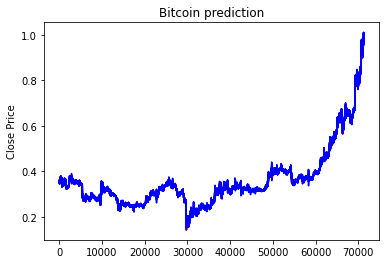

In [307]:
# Visualizing the results
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.title('Bitcoin prediction')
plt.ylabel('Close Price')
plt.show()

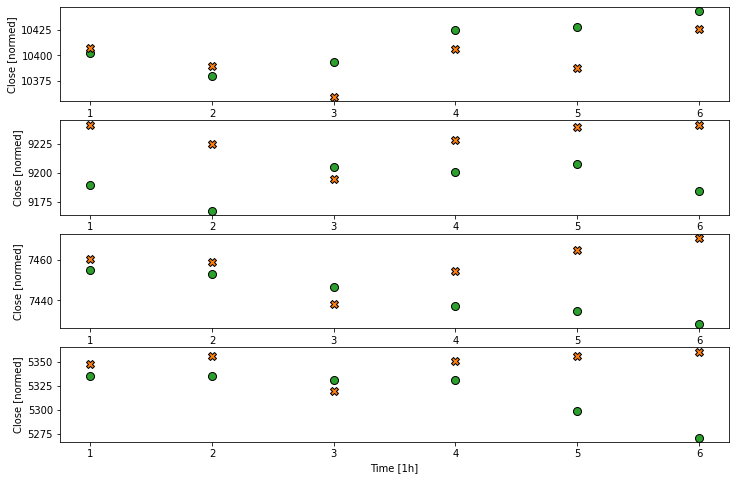

In [308]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=4, print_step = 10000)

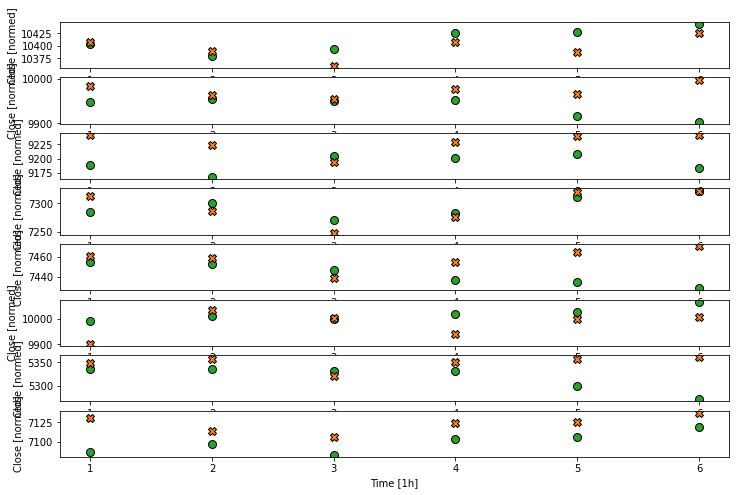

In [309]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=8, print_step = 5000)

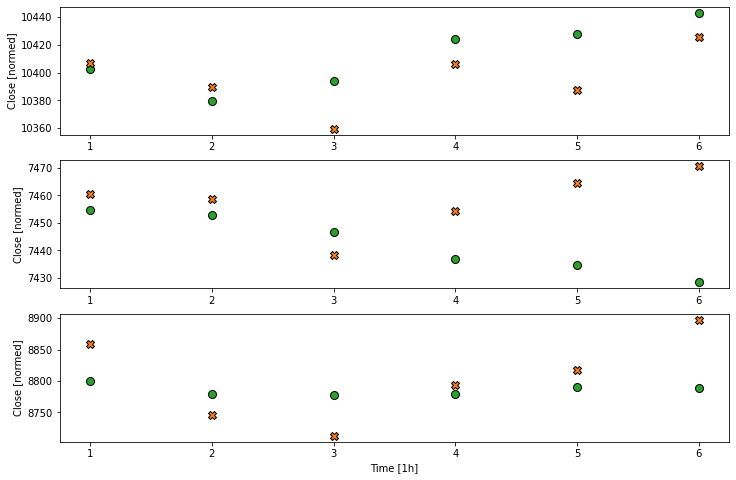

In [310]:
 plot(real_values, predictions,  plot_col='Close', max_subplots=3, print_step = 20000)